In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import keras_tuner as kt

# Loading Data

In [3]:
def load_data():
    unames = ['user_id', 'gender', 'age', 'occupation', 'zipCode']
    users = pd.read_csv('data/users.dat', sep='::',
    header=None, names=['user_id', 'gender', 'age', 'occupation', 'zipCode'], engine='python')
    ratings = pd.read_csv('data/ratings.dat', sep='::',
    header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
    movies = pd.read_csv('data/movies.dat', sep='::',
    header=None, names=['movie_id', 'title', 'genres'], engine='python', encoding='ISO-8859-1')
    return users, movies, ratings

In [4]:
users, movies, ratings = load_data()

# Exploring and Prepearing Data 

In [5]:
users.head(), movies.head(), ratings.head()

(   user_id gender  age  occupation zipCode
 0        1      F    1          10   48067
 1        2      M   56          16   70072
 2        3      M   25          15   55117
 3        4      M   45           7   02460
 4        5      M   25          20   55455,
    movie_id                               title                        genres
 0         1                    Toy Story (1995)   Animation|Children's|Comedy
 1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
 2         3             Grumpier Old Men (1995)                Comedy|Romance
 3         4            Waiting to Exhale (1995)                  Comedy|Drama
 4         5  Father of the Bride Part II (1995)                        Comedy,
    user_id  movie_id  rating  timestamp
 0        1      1193       5  978300760
 1        1       661       3  978302109
 2        1       914       3  978301968
 3        1      3408       4  978300275
 4        1      2355       5  978824291)

###  Inspecting min - max and nan values 

In [6]:
ratings['rating'].max(), ratings['rating'].min(), ratings['rating'].isna().sum()

(5, 1, 0)

### All users have at least one rating but there is 177 non-rated movie.

In [7]:
len(ratings['movie_id'].unique()), len(ratings['user_id'].unique())

(3706, 6040)

In [8]:
len(movies['movie_id'].unique()), len(users['user_id'].unique())

(3883, 6040)

### There is no user rate the same movie more than once.

In [9]:
temp = ratings.groupby(['user_id', 'movie_id'])['rating'].count().reset_index()
temp['rating'].max(), temp['rating'].min()

(1, 1)

### Scoring function that can capture interactions between users and items
- Assumption : User's current ratings are more important.
In order to implement this, first I converted the time stamp to datetime.

In [10]:
ratings['time'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['time'].max(), ratings['time'].min()

(Timestamp('2003-02-28 17:49:50'), Timestamp('2000-04-25 23:05:32'))

Then I normalized the dates between 0-1 as weights. Then I multiply them with ratings and again I normalized those scores between 0-1. Thus, the movies that the user voted most recently will be more important.

In [11]:
delta = ratings['time'].max() - ratings['time'].min()
ratings['weight'] = (ratings['time'] - ratings['time'].min())/delta
ratings['new_score'] = ratings['rating'] * ratings['weight']
ratings['new_score'] = (ratings['new_score'] - ratings['new_score'].min())/(ratings['new_score'].max() - ratings['new_score'].min())

Mapping function creates unique indexes for users and movies.

In [140]:
def map_indexes(df: pd.DataFrame):
    ALL_USERS = df['user_id'].unique().tolist()
    ALL_MOVIES = df['movie_id'].unique().tolist()
    user_ids = dict(list(enumerate(ALL_USERS)))
    movie_ids = dict(list(enumerate(ALL_MOVIES)))
    user_map = {u: m for m, u in user_ids.items()}
    movie_map = {m: u for u, m in movie_ids.items()}
    df['user'] = df['user_id'].map(user_map)
    df['movie'] = df['movie_id'].map(movie_map)
    return df, user_map, movie_map

In [141]:
ratings, user_map, movie_map = map_indexes(ratings)

In [142]:
ratings.head()

,user_id,movie_id,rating,timestamp,time,weight,new_score,user,movie
0,1,1193,5,978300760,2000-12-31 22:12:40,0.240631,0.240632,0,0
1,1,661,3,978302109,2000-12-31 22:35:09,0.240646,0.144388,0,1
2,1,914,3,978301968,2000-12-31 22:32:48,0.240645,0.144387,0,2
3,1,3408,4,978300275,2000-12-31 22:04:35,0.240626,0.192501,0,3
4,1,2355,5,978824291,2001-01-06 23:38:11,0.246465,0.246465,0,4


# Train - Test - Validation Split

In [15]:
def split_data(df: pd.DataFrame, test_size: float=0.1, val_size: float=0.1):
    df = df.sample(frac=1, random_state=42)
    X = df[['user', 'movie']].values
    Y = df['new_score'].values
    train_idx = int(len(df)*(1-test_size))
    X_train, X_test, Y_train, Y_test = X[:train_idx], X[train_idx:], Y[:train_idx], Y[train_idx:]
    train_idx = int(len(X_train)*(1-val_size))
    X_train, X_val, Y_train, Y_val = X_train[:train_idx], X_train[train_idx:], Y_train[:train_idx], Y_train[train_idx:]
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [45]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(ratings, test_size=0.1, val_size=0.12)

In [46]:
len(X_train), len(X_test), len(X_val)

(792165, 100021, 108023)

# Base Model : NN Collaborative Filtering Model

In [18]:
def nncf_model(embedding_dim: int) -> tf.keras.Model:
    # creating embedding layer
    user_input = tf.keras.layers.Input(shape=[1], name='user_input')
    user_embedding = tf.keras.layers.Embedding(
        input_dim=len(ratings['user_id'].unique()), 
        output_dim=embedding_dim, 
        embeddings_initializer="he_normal",
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
    # Flatten the user vector
    user_vec = tf.keras.layers.Flatten()(user_embedding)

    movie_input = tf.keras.layers.Input(shape=[1], name='movie_input')
    movie_embedding = tf.keras.layers.Embedding(
        input_dim=len(ratings['movie_id'].unique()), 
        output_dim=embedding_dim, 
        embeddings_initializer="he_normal",
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie_input)
    # Flatten the movie vector
    movie_vec = tf.keras.layers.Flatten()(movie_embedding)
    # Dense Layers
    dense_layer1 = tf.keras.layers.Dense(30, activation='relu', kernel_initializer="he_normal")(movie_vec)
    dense_layer2 = tf.keras.layers.Dense(10, activation='relu', kernel_initializer="he_normal")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(embedding_dim, activation='relu', kernel_initializer="he_normal")(dense_layer2)

    dense_layer4 = tf.keras.layers.Dense(30, activation='relu', kernel_initializer="he_normal")(user_vec)
    dense_layer5 = tf.keras.layers.Dense(10, activation='relu', kernel_initializer="he_normal")(dense_layer4)
    dense_layer6 = tf.keras.layers.Dense(embedding_dim, activation='relu', kernel_initializer="he_normal")(dense_layer5)

    # Dot product of user and movie embeddings
    dot_product = tf.keras.layers.Dot(axes=1)([dense_layer6, dense_layer3])
    prediction = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(dot_product)
    model = tf.keras.models.Model(inputs=[user_input, movie_input], outputs=prediction)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model
    

In [47]:
model = nncf_model(embedding_dim=50)

In [48]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        302000      ['user_input[0][0]']             
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 50)        185300      ['movie_input[0][0]']            
                                                                                            

# Train the Model

In [49]:
history = model.fit([X_train[:, 0], X_train[:,1]], Y_train, epochs=10, batch_size=64, validation_data=([X_test[:, 0], X_test[:,1]], Y_test))

Epoch 1/10
12378/12378 [==============================] - 37s 3ms/step - loss: 0.3508 - val_loss: 0.3490
Epoch 2/10
12378/12378 [==============================] - 36s 3ms/step - loss: 0.3485 - val_loss: 0.3485
Epoch 3/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3480 - val_loss: 0.3480
Epoch 4/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3476 - val_loss: 0.3479
Epoch 5/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3474 - val_loss: 0.3480
Epoch 6/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3473 - val_loss: 0.3477
Epoch 7/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3472 - val_loss: 0.3477
Epoch 8/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3471 - val_loss: 0.3477
Epoch 9/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.3471 - val_loss: 0.3477
Epoch 10/10
12378/12378 [==============================

In [43]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

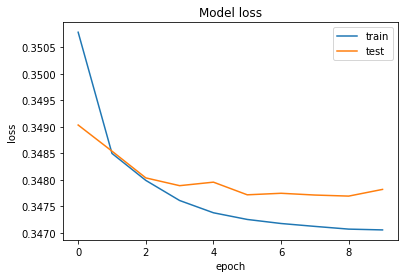

In [50]:
plot_loss(history)

# Make Recommendations for User

I created new data frame for comparing the predicted and rated values.

In [21]:
def get_prediction(model: tf.keras.Model, X_test: np.ndarray, Y_test: np.ndarray) -> pd.DataFrame:
    test_df = ['user_id', 'movie_id', 'rating', 'prediction']
    test_df = pd.DataFrame(columns=test_df)
    test_df['user_id'] = X_test[:, 0]
    test_df['movie_id'] = X_test[:, 1]
    test_df['rating'] = Y_test
    test_df['prediction'] = model.predict([X_test[:, 0], X_test[:, 1]])
    return test_df

In [51]:
test_df = get_prediction(model, X_test, Y_test)

### Evaulation of Hit Ratio
The value of loss function actually doesn't give a solid idea about performance of the model. In order to evaulate model I calculated the hitting ratio, simply I compared the highest rated top n movies and top n recommened movies  of the user.

In [22]:
def calculate_hit_rate(reco_movie_ids, pred_movie_ids, n):
  hits = 0
  for movie_id in reco_movie_ids:
    if movie_id in pred_movie_ids:
      hits += 1
  return hits / n

### Hit Ratio of the Whole Model

In [23]:
def calculate_avg_hit_rate(test_df: pd.DataFrame, n: Int=5) -> float:
    total_hits = 0
    for user_id in test_df['user_id'].unique():
        hit_rate, _, _ = make_recommendations(user_id, test_df, n=5)
        total_hits += hit_rate
    return total_hits / len(test_df['user_id'].unique())

In [24]:
def make_recommendations(user_id: Int, test_df: pd.DataFrame, n: Int=5):
  user_ratings = test_df[test_df['user_id'] == user_id]
  user_ratings= pd.merge(
    user_ratings, movies, on="movie_id"
  ).sort_values(by='rating', ascending=False)
  user_ratings = user_ratings.head(n)
  preds = test_df[test_df['user_id'] == user_id]
  preds= pd.merge(
    preds, movies, on="movie_id"
  ).sort_values(by='prediction', ascending=False)
  preds = preds.head(n)
  hit_rate = calculate_hit_rate(user_ratings['movie_id'].tolist(), preds['movie_id'].tolist(), n)
  return hit_rate, user_ratings, preds

In [54]:
hit_rate, user_ratings, preds = make_recommendations(28, test_df, n=5)
print('Preferred items of user')
print(user_ratings)
print('Recommended items of user')
print(preds)
print('Hit rate:', hit_rate)

Preferred items of user
    user_id  movie_id    rating  prediction  \
8        28       615  0.238796    0.161973   
5        28      1475  0.238795    0.181908   
9        28       210  0.238794    0.184375   
10       28       718  0.238652    0.198168   
2        28       669  0.238650    0.199251   

                                             title         genres  
8   Bread and Chocolate (Pane e cioccolata) (1973)          Drama  
5                Kama Sutra: A Tale of Love (1996)        Romance  
9                                 Wild Bill (1995)        Western  
10            Visitors, The (Les Visiteurs) (1993)  Comedy|Sci-Fi  
2                                 Aparajito (1956)          Drama  
Recommended items of user
    user_id  movie_id    rating  prediction  \
2        28       669  0.238650    0.199251   
10       28       718  0.238652    0.198168   
9        28       210  0.238794    0.184375   
5        28      1475  0.238795    0.181908   
7        28       711  0

### Mean Hit Ratio of the Model

In [55]:
mean_hit_rate = calculate_avg_hit_rate(test_df, n=5)

In [56]:
mean_hit_rate

0.5307485733467653

# Hyper Parameter Tuning with Keras Tuner on Validation Data

Rewrite the model with hyperparameters : 

In [96]:
def nncf_model_hp(hp):
    """
    Hyperparameter search space for NNCF model
    Hyperparameters:
    embedding_dim: int (default: 50)
    L2 Regularization Coefficient: float (default: 1e-6)
    Learning Rate For Model Optimizer : float (default: 0.001)
    
    """
    hp_embed_dims = hp.Int('embedding_dim', min_value=40, max_value=80, step=20)
    hp_reg_coef = hp.Choice('reg_coeff', values=[1e-4, 1e-6, 1e-8])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    user_input = tf.keras.layers.Input(shape=[1], name='user_input')
    user_embedding = tf.keras.layers.Embedding(
        input_dim=len(ratings['user_id'].unique()), 
        output_dim=hp_embed_dims, 
        embeddings_initializer="he_normal",
        embeddings_regularizer=tf.keras.regularizers.l2(hp_reg_coef))(user_input)
    user_vec = tf.keras.layers.Flatten()(user_embedding)

    movie_input = tf.keras.layers.Input(shape=[1], name='movie_input')
    movie_embedding = tf.keras.layers.Embedding(
        input_dim=len(ratings['movie_id'].unique()), 
        output_dim=hp_embed_dims, 
        embeddings_initializer="he_normal",
        embeddings_regularizer=tf.keras.regularizers.l2(hp_reg_coef))(movie_input)
    movie_vec = tf.keras.layers.Flatten()(movie_embedding)

    dense_layer1 = tf.keras.layers.Dense(30, activation='relu', kernel_initializer="he_normal")(movie_vec)
    dense_layer2 = tf.keras.layers.Dense(10, activation='relu', kernel_initializer="he_normal")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(hp_embed_dims, activation='relu', kernel_initializer="he_normal")(dense_layer2)

    dense_layer4 = tf.keras.layers.Dense(30, activation='relu', kernel_initializer="he_normal")(user_vec)
    dense_layer5 = tf.keras.layers.Dense(10, activation='relu', kernel_initializer="he_normal")(dense_layer4)
    dense_layer6 = tf.keras.layers.Dense(hp_embed_dims, activation='relu', kernel_initializer="he_normal")(dense_layer5)

    dot_product = tf.keras.layers.Dot(axes=1)([dense_layer6, dense_layer3])

    prediction = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(dot_product)
    model = tf.keras.models.Model(inputs=[user_input, movie_input], outputs=prediction)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='binary_crossentropy')
    return model

In [99]:
tuner = kt.Hyperband(nncf_model_hp,
                    objective='val_loss',
                    max_epochs=6,
                    factor=3,
                    directory='nncf_tuner', 
                    project_name='nncf')

In [100]:
tuner.search([X_train[:, 0], X_train[:,1]], Y_train, epochs=10, batch_size=64, validation_data=([X_val[:, 0], X_val[:,1]], Y_val), callbacks=[tf.keras.callbacks.TensorBoard("nncf_tuner/tb_logs")])

Trial 10 Complete [00h 03m 22s]
val_loss: 0.3475494384765625

Best val_loss So Far: 0.34737256169319153
Total elapsed time: 00h 27m 41s
INFO:tensorflow:Oracle triggered exit


In [101]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of embedding dimension is {best_hps.get('embedding_dim')},  and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')} and the optimal L2 regularization coefficient of embeddings is {best_hps.get('reg_coeff')}.
""")
tuner.search_space_summary()


The hyperparameter search is complete. The optimal number of embedding dimension is 40,  and the optimal learning rate for the optimizer is 1e-05 and the optimal L2 regularization coefficient of embeddings is 1e-08.

Search space summary
Default search space size: 3
embedding_dim (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 80, 'step': 20, 'sampling': None}
reg_coeff (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-06, 1e-08], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


### Build and Retrain the Model

In [102]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([X_train[:, 0], X_train[:,1]], Y_train, epochs=10, batch_size=64, validation_data=([X_test[:, 0], X_test[:,1]], Y_test))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
12378/12378 [==============================] - 33s 3ms/step - loss: 0.4133 - val_loss: 0.3532
Epoch 2/10
12378/12378 [==============================] - 31s 2ms/step - loss: 0.3497 - val_loss: 0.3484
Epoch 3/10
12378/12378 [==============================] - 30s 2ms/step - loss: 0.3477 - val_loss: 0.3477
Epoch 4/10
12378/12378 [==============================] - 31s 2ms/step - loss: 0.3473 - val_loss: 0.3475
Epoch 5/10
12378/12378 [==============================] - 31s 2ms/step - loss: 0.3472 - val_loss: 0.3475
Epoch 6/10
12378/12378 [==============================] - 31s 2ms/step - loss: 0.3472 - val_loss: 0.3475
Epoch 7/10
12378/12378 [==============================] - 31s 3ms/step - loss: 0.3471 - val_loss: 0.3475
Epoch 8/10
12378/12378 [==============================] - 31s 3ms/step - loss: 0.3471 - val_loss: 0.3474
Epoch 9/10
12378/12378 [==============================] - 31s 2ms/step - loss: 0.3471 - val_loss: 0.3474
Epoch 10/10
12378/12378 [==============================

In [105]:
tuned_test_df = get_prediction(model, X_test, Y_test)
tuned_mean_hit_rate = calculate_avg_hit_rate(tuned_test_df, n=5)
tuned_mean_hit_rate

0.5219201074186003

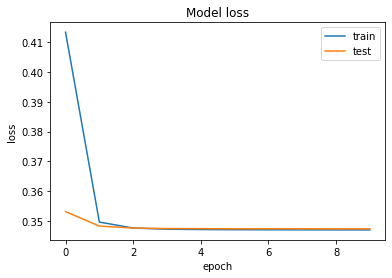

In [104]:
plot_loss(history)

### Save Model

In [106]:
!mkdir -p saved_model
model.save('saved_model/tuned_model')

2022-05-07 15:23:28.012698: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/tuned_model/assets


### Making 5 Recommendation to given user

User ids : 0 - 6039

In [409]:
def make_reco_to_user(model, df, movies, user_id, n=5):
    seen_movie_ids = df[df['user'] == user_id]['movie'].values
    not_seen_movies = movies[~movies['movie_id'].isin(seen_movie_ids)]['movie_id']
    not_seen_movies = list(set(not_seen_movies).intersection(set(movie_map.keys())))
    reco = ['user_id', 'movie_id','prediction']
    reco = pd.DataFrame(columns=reco)
    res = ['user_id', 'movie_id', 'prediction']
    res = pd.DataFrame(columns=res)
    reco['user_id'] = np.full(len(df['user'].values), user_id, dtype = np.int64)
    reco['movie_id'] = df['movie'].values
    X = reco[['user_id', 'movie_id']].values
    reco['prediction'] = model.predict([X[:, 0], X[:, 1]])
    reco= pd.merge(reco, movies, on="movie_id")
    reco = reco.sort_values(by='prediction', ascending=False).drop_duplicates(subset=['user_id', 'movie_id'], keep='first')
    count = 0
    for i in range(len(reco)):
        if reco['movie_id'].values[i] in not_seen_movies:
            res = res.append(reco.iloc[i, :])
            count = count + 1
            if count == n:
                break
    return res, reco

In [410]:
res, recos = make_reco_to_user(model, ratings, movies, 1253, n=5)
print('Recommended items of user')
print(res)

Recommended items of user
       user_id movie_id prediction          genres  \
955584    1253     2715   0.372313  Comedy|Romance   
935596    1253     2453   0.356195   Drama|Fantasy   
792704    1253     1485   0.335976          Comedy   
947074    1253     2587   0.283401          Comedy   
976286    1253     3237   0.281373     Documentary   

                                     title  
955584        Velocity of Gary, The (1998)  
935596       Boy Who Could Fly, The (1986)  
792704                    Liar Liar (1997)  
947074                         Life (1999)  
976286  Kestrel's Eye (Falkens öga) (1998)  


/var/folders/74/j1wwdzv12_gdkxxh7r_y7h480000gn/T/ipykernel_28252/67678221.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(reco.iloc[i, :])
/var/folders/74/j1wwdzv12_gdkxxh7r_y7h480000gn/T/ipykernel_28252/67678221.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(reco.iloc[i, :])
/var/folders/74/j1wwdzv12_gdkxxh7r_y7h480000gn/T/ipykernel_28252/67678221.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(reco.iloc[i, :])
/var/folders/74/j1wwdzv12_gdkxxh7r_y7h480000gn/T/ipykernel_28252/67678221.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(reco.iloc[i, :])
